# 1. Discussion and Background of the Business Problem:

Vegetarian/Vegan Restaurants

The capstone project explores the best locations for Vegetarian and Vegan people. New York is a major metropolitan area with more than 8,419 million (United States Census Bureau, 2019) people living within city limits. In addtition, New York is a popluar tourist point for people from all over the world. New York City is the largest city in the United States with a long history of international immigration. According to Top Trends in Prepared Foods 2017 report 8% of the US population is vegeterian and 6% of the US population is vegan. Hence, vegetarian/vegan food treind is getting more popular, it is important for natives and tourits to get access to the best restaruants. 


## Target Audience
* Business personnel who wants to invest or open a vegan/vegetarian restaurant.
* The eco-friendly people who care about planet and eat responsibly
* Finding the best location for opening a restaurant.
* Exploratory Data Analysis techniques to obtain necessary data, analyze it and, finally be able to tell a story out of it.


## Problem Statement
1. What is the best location for an Vegan/Vegetarian restaurant in New York City?
2. In what Neighborhood should I open a Vegan/Vegetarian restaurant to have the best chance of being successful?
3. The hint map where tourists/natives can find the biggest number of Vegan/Vegetarian restaurants


## Data Section
For this project the following data was used:

1. New York City data that contains Borough, Neighborhoods along with their coordinates (latitudes and longitudes)
    * Data Source: https://cocl.us/new_york_dataset
    * Description: This data set contains the required information. And we will use this data set to explore various neighborhoods of New York city.
2. Vegan/Vegetarian restaurants in all neighborhood of New York city (focusing only on one neighborhood) .
    * Data Source: Foursquare API
    * Description: By using this API we will get all the venues in the Queens neighborhood. We can filter these venues to get only Vegetarian/Vegan restaurants.
    

# Solution implementation, not for validation it is a preparation for week 2

In [12]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [32]:
CLIENT_ID = 'B2LGB1M5TNDZSN2CUOMS3A3LWZ05DC4S2L3EYKV10D3RCYAU' # your Foursquare ID
CLIENT_SECRET = 'IQNCKAUJOASZ0VL0E45VU1FLO4OZYDUT1AFOTKHPSRTPVCML' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [63]:
import getpass
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests
ACCESS_TOKEN = 'B1VM2KPPEXKRFTYWXX441KNFTECPJA35X0OW5HSV5G22TH12' # your FourSquare Access Token
CLIENT_SECRET = 'VXQHIW1GN2LHTI4TECUUDCFMIVLHHRT2JVBDTMYVE1EFZ2PC'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
#CLIENT_ID = getpass.getpass('Enter your CLIENT_ID')
CLIENT_ID = 'EAGYUIHIGUIHHQLOKPW4EFIRSZM2QOABDDDB1LLPB00ETRRJ'

In [64]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [34]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [35]:
ny_data.shape


(306, 4)

In [36]:
ny_data['Borough'].nunique()

5

In [65]:
# queens has most neighborhoods
# prepare neighborhood list that contains Indian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
#count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_restaurants=venues[venues['Category']=='Vegetarian / Vegan Restaurant']   
    #print('(',count,'/',len(ny_data),')','Indian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(indian_restaurants)))
    #print(row)
    for resturant_detail in indian_restaurants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    #count+=1

KeyError: 'groups'

In [44]:
indian_rest_ny

,Borough,Neighborhood,ID,Name
0,Bronx,Belmont,5a5be0a81108ba5892aa3d0d,Çka Ka Qëllu
1,Brooklyn,Brighton Beach,4e23642088774a43b77e02c3,Cafe Euroasia
2,Brooklyn,Brighton Beach,4beed18235dc0f47b952405b,Домашняя кухня
3,Manhattan,Lenox Hill,5d02cb063731ee002c297fe9,Oda House
4,Manhattan,Greenwich Village,53bacc8f498e55a100c4010e,Old Tbilisi Garden
5,Queens,Rockaway Beach,5777fc88498ec5cc1755d079,Uma's
6,Staten Island,Rosebank,57b2645dcd1036625d521e0b,Korzo Klub
7,Staten Island,Grant City,4fa6a903e4b0bbcd4ad315fd,Sorry babushka
8,Staten Island,Clifton,57b2645dcd1036625d521e0b,Korzo Klub
9,Bronx,Bronxdale,4bae4854f964a520ec9c3be3,Dukagjini Burek


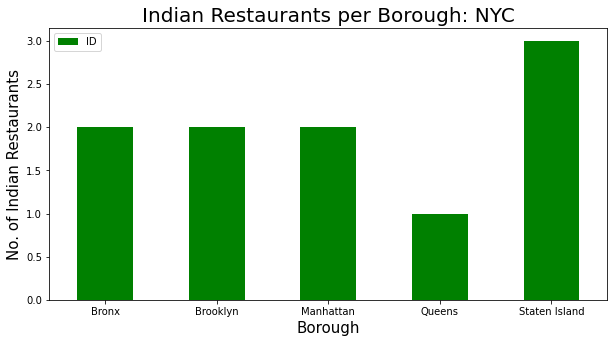

In [46]:
clr='green'
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

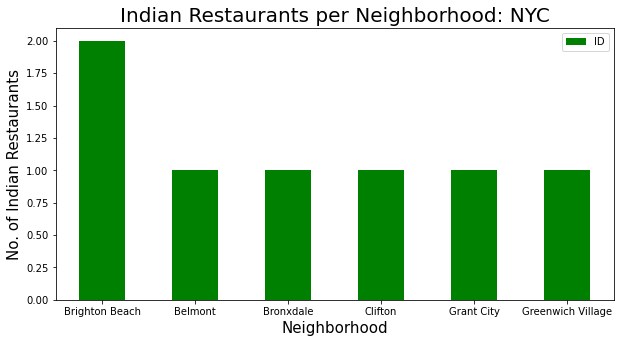

In [47]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Indian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [48]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
#count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    #count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60ba011ecb70006492363775'}, 'response': {'venue': {'id': '5a5be0a81108ba5892aa3d0d', 'name': 'Çka Ka Qëllu', 'contact': {'phone': '7189336194', 'formattedPhone': '(718) 933-6194'}, 'location': {'address': '2324-2370 Hughes Ave.', 'lat': 40.853835, 'lng': -73.888021, 'labeledLatLngs': [{'label': 'display', 'lat': 40.853835, 'lng': -73.888021}], 'postalCode': '10458', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2324-2370 Hughes Ave.', 'New York, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/%C3%A7ka-ka-q%C3%ABllu/5a5be0a81108ba5892aa3d0d', 'categories': [{'id': '4bf58dd8d48988d109941735', 'name': 'Eastern European Restaurant', 'pluralName': 'Eastern European Restaurants', 'shortName': 'Eastern European', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tie

{'meta': {'code': 200, 'requestId': '60ba011f193c26055663f1f4'}, 'response': {'venue': {'id': '4e23642088774a43b77e02c3', 'name': 'Cafe Euroasia', 'contact': {'phone': '7188910008', 'formattedPhone': '(718) 891-0008'}, 'location': {'address': '602 Brighton Beach Ave', 'lat': 40.577408, 'lng': -73.961244, 'labeledLatLngs': [{'label': 'display', 'lat': 40.577408, 'lng': -73.961244}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['602 Brighton Beach Ave', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-euroasia/4e23642088774a43b77e02c3', 'categories': [{'id': '4bf58dd8d48988d109941735', 'name': 'Eastern European Restaurant', 'pluralName': 'Eastern European Restaurants', 'shortName': 'Eastern European', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '60ba01201d9d4e7451cb369d'}, 'response': {'venue': {'id': '5d02cb063731ee002c297fe9', 'name': 'Oda House', 'contact': {'phone': '6469985152', 'formattedPhone': '(646) 998-5152'}, 'location': {'address': '406 E 73rd St', 'lat': 40.768142, 'lng': -73.95497, 'labeledLatLngs': [{'label': 'display', 'lat': 40.768142, 'lng': -73.95497}], 'postalCode': '10021', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['406 E 73rd St', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oda-house/5d02cb063731ee002c297fe9', 'categories': [{'id': '4bf58dd8d48988d109941735', 'name': 'Eastern European Restaurant', 'pluralName': 'Eastern European Restaurants', 'shortName': 'Eastern European', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'cur

{'meta': {'code': 200, 'requestId': '60ba012070a87928eb4ba97c'}, 'response': {'venue': {'id': '5777fc88498ec5cc1755d079', 'name': "Uma's", 'contact': {}, 'location': {'lat': 40.582863, 'lng': -73.817733, 'labeledLatLngs': [{'label': 'display', 'lat': 40.582863, 'lng': -73.817733}], 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Queens, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/umas/5777fc88498ec5cc1755d079', 'categories': [{'id': '4bf58dd8d48988d109941735', 'name': 'Eastern European Restaurant', 'pluralName': 'Eastern European Restaurants', 'shortName': 'Eastern European', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 5, 'groups': [{'type': 'others', 'count': 5, 'items': [{'firstName': 'Robert', 'lastName': 'G', 'address': ''

{'meta': {'code': 200, 'requestId': '60ba0121dcdbda54cd7d27fe'}, 'response': {'venue': {'id': '4fa6a903e4b0bbcd4ad315fd', 'name': 'Sorry babushka', 'contact': {}, 'location': {'address': '2230 Hylan Blvd', 'lat': 40.575965000000004, 'lng': -74.103531, 'labeledLatLngs': [{'label': 'display', 'lat': 40.575965000000004, 'lng': -74.103531}, {'label': 'entrance', 'lat': 40.576018, 'lng': -74.10363}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2230 Hylan Blvd', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sorry-babushka/4fa6a903e4b0bbcd4ad315fd', 'categories': [{'id': '4bf58dd8d48988d109941735', 'name': 'Eastern European Restaurant', 'pluralName': 'Eastern European Restaurants', 'shortName': 'Eastern European', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'p

{'meta': {'code': 200, 'requestId': '60ba01221008183f46bd5946'}, 'response': {'venue': {'id': '4bae4854f964a520ec9c3be3', 'name': 'Dukagjini Burek', 'contact': {}, 'location': {'address': '758 Lydig Ave', 'lat': 40.854479908427884, 'lng': -73.86541171889682, 'labeledLatLngs': [{'label': 'display', 'lat': 40.854479908427884, 'lng': -73.86541171889682}, {'label': 'entrance', 'lat': 40.854372, 'lng': -73.865431}], 'postalCode': '10462', 'cc': 'US', 'neighborhood': 'Pelham Parkway', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['758 Lydig Ave', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dukagjini-burek/4bae4854f964a520ec9c3be3', 'categories': [{'id': '4bf58dd8d48988d109941735', 'name': 'Eastern European Restaurant', 'pluralName': 'Eastern European Restaurants', 'shortName': 'Eastern European', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'verified': Fa

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
5,Queens,Rockaway Beach,5777fc88498ec5cc1755d079,Uma's,5,6.3,2
6,Staten Island,Rosebank,57b2645dcd1036625d521e0b,Korzo Klub,9,7.4,2
7,Staten Island,Grant City,4fa6a903e4b0bbcd4ad315fd,Sorry babushka,4,6.2,4
8,Staten Island,Clifton,57b2645dcd1036625d521e0b,Korzo Klub,9,7.4,2
9,Bronx,Bronxdale,4bae4854f964a520ec9c3be3,Dukagjini Burek,6,6.1,4


In [50]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       10 non-null     object 
 1   Neighborhood  10 non-null     object 
 2   ID            10 non-null     object 
 3   Name          10 non-null     object 
 4   Likes         10 non-null     object 
 5   Rating        10 non-null     float64
 6   Tips          10 non-null     object 
dtypes: float64(1), object(6)
memory usage: 688.0+ bytes


In [51]:
indian_rest_stats_ny['Likes'] = indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips'] = indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       10 non-null     object 
 1   Neighborhood  10 non-null     object 
 2   ID            10 non-null     object 
 3   Name          10 non-null     object 
 4   Likes         10 non-null     float64
 5   Rating        10 non-null     float64
 6   Tips          10 non-null     float64
dtypes: float64(3), object(4)
memory usage: 688.0+ bytes


In [52]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,10.000000,10.000000,10.000000
mean,19.900000,7.120000,7.600000
std,36.345411,0.820298,11.187294
min,4.000000,6.100000,2.000000
25%,6.250000,6.300000,2.500000
50%,9.000000,7.400000,4.000000
75%,12.000000,7.700000,6.500000
max,123.000000,8.200000,39.000000


In [53]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood           Greenwich Village
ID              53bacc8f498e55a100c4010e
Name                  Old Tbilisi Garden
Likes                                123
Rating                               8.1
Tips                                  39
Name: 4, dtype: object

In [54]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                     Belmont
ID              5a5be0a81108ba5892aa3d0d
Name                        Çka Ka Qëllu
Likes                                 12
Rating                               8.2
Tips                                   5
Name: 0, dtype: object

In [55]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]


Borough                        Manhattan
Neighborhood           Greenwich Village
ID              53bacc8f498e55a100c4010e
Name                  Old Tbilisi Garden
Likes                                123
Rating                               8.1
Tips                                  39
Name: 4, dtype: object

In [56]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Belmont,8.20
5,Greenwich Village,8.10
6,Lenox Hill,7.80
3,Clifton,7.40
8,Rosebank,7.40
1,Brighton Beach,6.85
7,Rockaway Beach,6.30
4,Grant City,6.20
2,Bronxdale,6.10


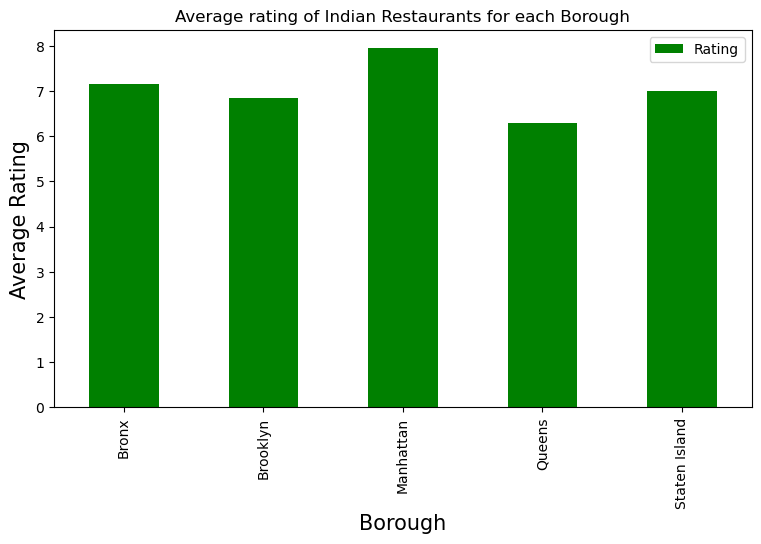

In [57]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [58]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Belmont,40.857277,-73.888452,8.20
1,Brooklyn,Brighton Beach,40.576825,-73.965094,6.85
2,Bronx,Bronxdale,40.852723,-73.861726,6.10
3,Staten Island,Clifton,40.619178,-74.072642,7.40
4,Staten Island,Grant City,40.576216,-74.105856,6.20
5,Manhattan,Greenwich Village,40.726933,-73.999914,8.10
6,Manhattan,Lenox Hill,40.768113,-73.958860,7.80
7,Queens,Rockaway Beach,40.582802,-73.822361,6.30
8,Staten Island,Rosebank,40.615305,-74.069805,7.40


In [59]:

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [61]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)